In [1]:
from Diagnostic_analysis import load_data, clean_data, split_data, scale_data, train_model, print_evaluation

# Analisi Diagnostica
* **Dataset:** Breast Cancer Wisconsin (Diagnostic)
* **Task:** Sviluppare un modello predittivo capace di classificare i campioni cellulari come
Maligni o Benigni sulla base delle caratteristiche morfologiche rilevate

### 1. Loading & Preprocessing

* **Feature Selection:** Rimozione degli attributi non informativi (es. ID paziente) o affetti da null values strutturali.
* **Target Encoding:** Conversione della variabile categorica `diagnosis` in formato numerico binario ($M=1, B=0$) per renderla compatibile con l'algoritmo di classificazione

In [2]:
df = clean_data(load_data())

In [3]:
display(df.head())

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### 2. Dataset Splitting

Per valutare la capacità di generalizzazione del modello e prevenire l'overfitting, si effettua uno split 80-20.
Il dataset viene partizionato in due sottoinsiemi disgiunti:
* **Training Set (80%):** Utilizzato per l'ottimizzazione dei parametri del modello.
* **Test Set (20%):** Utilizzato esclusivamente per la valutazione finale su dati non visti.

In [4]:
X_train_raw, X_test_raw, y_train, y_test = split_data(df)

### 3. Fetature Scaling (Normalizzazione)

Le feature morfologiche presentano ordini di grandezza eterogenei (es. Area $\approx 1000$ vs Smoothness $\approx 0.1$).
Per garantire la corretta convergenza dell'algoritmo e uniformare il peso delle variabili, si applica una Standardizzazione (Z-score normalization) per ottenere feature con media $0$ e varianza unitaria.

> **Nota:** Il fitting dello scaler avviene esclusivamente sul **Training Set** per evitare il fenomeno del **Data Leakage**. I parametri statistici (media e deviazione standard) appresi vengono poi applicati per trasformare il Test Set.

In [5]:
X_train, X_test = scale_data(X_train_raw, X_test_raw)

### 4. Training & Evaluation

Si implementa un modello di **Logistic Regression**, scelto per la sua efficacia in problemi di classificazione binaria linearmente separabili e per l'interpretabilità dei coefficienti.

**Metriche di Valutazione:**
La performance viene analizzata sul Test Set monitorando:
* **Accuracy:** Accuratezza globale del classificatore.
* **Recall:** Capacità di individuare i casi positivi ($TP / (TP + FN)$).
* **Precision:** Affidabilità della predizione positiva ($TP / (TP + FP)$). Indica la capacità di ridurre i falsi allarmi.
* **F1-Score:** Media armonica tra Precision e Recall, offre una sintesi della robustezza del modello.
* **Confusion Matrix:** Analisi dettagliata dei residui (Falsi Positivi vs Falsi Negativi).

Accuracy: 97.37%

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



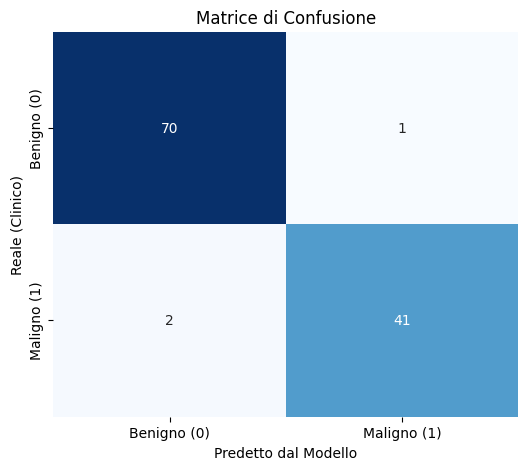

In [6]:
model = train_model(X_train, y_train)
print_evaluation(model, X_test, y_test)

## Conclusioni

Le performance sul Test Set confermano la validità del modello:

1.  **Metriche Globali:**
    * **Accuracy (97.37%):** Il classificatore discrimina correttamente la quasi totalità dei campioni.
    * **F1-Score (0.96):** Il valore elevato conferma che il modello mantiene un ottimo bilanciamento tra precisione e sensibilità, senza bias significativi verso una delle due classi.

2.  **Analisi Clinica (Classe Maligna):**
    * **High Recall (0.95):** Il sistema ha identificato 41 su 43 tumori maligni, dimostrandosi sicuro per lo screening.
    * **High Precision (0.98):** Quando il modello predice una malignità, la probabilità di errore (falso positivo) è minima, riducendo il rischio di over-diagnosis.